# Install dependencies

In [1]:
%env JOBLIB_TEMP_FOLDER=/tmp
!pip install pyspark

env: JOBLIB_TEMP_FOLDER=/tmp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 8)
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/'COMPSCI 532'/Project/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/COMPSCI 532/Project


In [4]:
%ls

'archive (1).zip'            'Missing values.jpeg'
 data/                       'Movie Recomendation ALS.ipynb'
 histogram.png                movie-recommendation-system-with-als.ipynb
 hs_err_pid1064.log          'pie chat.jpeg'
 links_missing.csv           'relase stats .png'
'links missing values.png'   'releasegraph .png'
'metadata (1).csv'            saved_model_large/
 metadata.csv                 saved_model_small/
 metadata_missing.csv        'user_stats .png'
'metadata missng.png'        'user word cloud .jpeg'
 metadat.csv                 'word cluld .jpeg'
'Missing Values count.jpeg'


In [5]:
DATA_PATH = './data/'

In [6]:
print('Data Files in Directory')
print(os.listdir(DATA_PATH))

Data Files in Directory
['credits.csv', 'links.csv', 'movies_metadata.csv', 'keywords.csv', 'links_small.csv', 'ratings.csv', 'ratings_small.csv']


# Load all datasets into pandas

In [7]:
ratings = pd.read_csv(DATA_PATH+'ratings.csv')
links = pd.read_csv(DATA_PATH+'links.csv')
metadata = pd.read_csv(DATA_PATH+'movies_metadata.csv')

<ipython-input-7-a6a179e262d9>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(DATA_PATH+'movies_metadata.csv')


In [8]:
credits = pd.read_csv(DATA_PATH+'credits.csv')
keywords = pd.read_csv(DATA_PATH+'keywords.csv')

# Analyze missing values

In [9]:
def get_missing_count(df):
    missing = df.isnull().sum()
    print('Missing Values')
    if missing.values.sum() == 0:
        print('No Missing Values')
    else:
        missing = missing[missing > 0]
        missing = pd.DataFrame({'Column' : missing.index, 'Missing Values' : missing.values})
        print(missing)

In [10]:
get_missing_count(ratings)

Missing Values
No Missing Values


In [11]:
get_missing_count(links)

Missing Values
   Column  Missing Values
0  tmdbId             219


In [12]:
get_missing_count(metadata)

Missing Values
                   Column  Missing Values
0   belongs_to_collection           40972
1                homepage           37684
2                 imdb_id              17
3       original_language              11
4                overview             954
5              popularity               5
6             poster_path             386
7    production_companies               3
8    production_countries               3
9            release_date              87
10                revenue               6
11                runtime             263
12       spoken_languages               6
13                 status              87
14                tagline           25054
15                  title               6
16                  video               6
17           vote_average               6
18             vote_count               6


In [13]:
get_missing_count(credits)

Missing Values
No Missing Values


In [14]:
get_missing_count(keywords)

Missing Values
No Missing Values


## Check from pyspark

In [15]:
import pyspark.sql.functions as sql_func
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.ml.evaluation import RegressionEvaluator

sc = SparkContext('local')
spark = SparkSession(sc)

In [16]:
data_schema = StructType([
    StructField('movieId', IntegerType(), False),
    StructField('imdbId', IntegerType(), False),
    StructField('tmdbId', IntegerType(), False)
])

final_stat = spark.read.csv(
    DATA_PATH + 'links.csv', header=True, schema=data_schema
)

links1 = (final_stat.select(
    'movieId',
    'imdbId',
    'tmdbId'
))

In [17]:
links1.filter("tmdbId is null").show()

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|    142| 94878|  null|
|    604|115978|  null|
|    720|118114|  null|
|    721|114103|  null|
|    730|125877|  null|
|    769|116992|  null|
|    770| 38426|  null|
|    791|113610|  null|
|    821|112746|  null|
|    859|116536|  null|
|   1107|102336|  null|
|   1122|114147|  null|
|   1133|111357|  null|
|   1141|113328|  null|
|   1142|116403|  null|
|   1155| 92281|  null|
|   1166|113031|  null|
|   1316|115548|  null|
|   1421|113212|  null|
|   1434|123281|  null|
+-------+------+------+
only showing top 20 rows



In [18]:
links1.filter("tmdbId is null").count()

219

# Exploratory Data Analysis

In [19]:
from collections import Counter

rating_freq = Counter(ratings['rating'])
a = sorted(rating_freq.items(), key=lambda x: x[0])

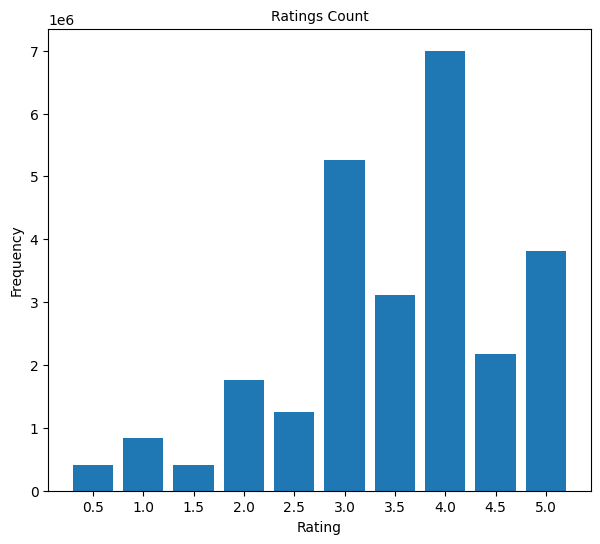

In [20]:
plt.rcParams['figure.figsize'] = (7, 6)
plt.title('Ratings Count', size=10)
plt.bar([i[0] for i in a], [i[1] for i in a], width=0.4)
plt.xticks(ticks=np.arange(0.5, 5.5, 0.5), labels=np.arange(0.5, 5.5, 0.5))
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

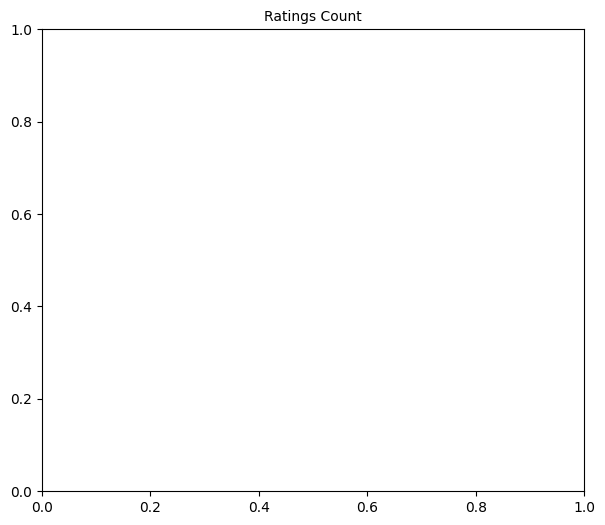

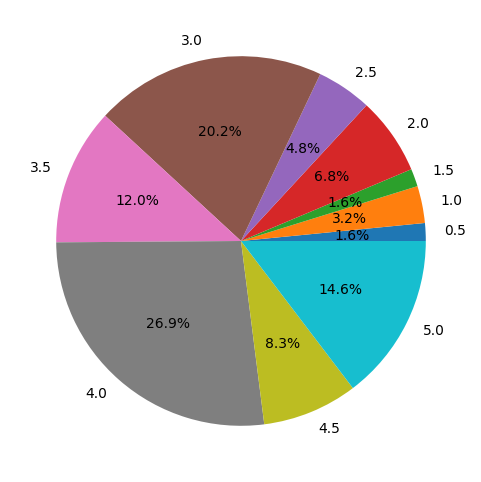

In [21]:
plt.rcParams['figure.figsize'] = (7, 6)
plt.title('Ratings Count', size=10)
fig, ax = plt.subplots()
ax.pie([i[1] for i in a], labels=[i[0] for i in a], autopct='%1.1f%%')
plt.show()

## Top 20 movies based on value counts

In [22]:
df_aux = ratings['movieId'].value_counts().reset_index().head(20).rename(columns={'index': 'movieId', 'movieId': 'count'})
df_aux['movieId'] = df_aux['movieId'].astype(str)
df_aux.head()

,movieId,count
0,356,91921
1,318,91082
2,296,87901
3,593,84078
4,2571,77960


Drop NA values

In [23]:
metadata = metadata[metadata['release_date'].notna()]

Get relevant movie data; function designed based on movie dataset description

In [24]:
# Get the Movie on metadata; Function designed based on
def get_metadata(movieId):
    metadata['imdb_id'] = metadata['imdb_id'].astype('category')
    imdb_id = links[links['movieId'] == movieId]
    imdb_id = imdb_id.imdbId.values[0]
    if len(str(imdb_id)) == 7:
        movie_rated = metadata[metadata['imdb_id'] == 'tt'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 6:
        movie_rated = metadata[metadata['imdb_id'] == 'tt0'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 5:
        movie_rated = metadata[metadata['imdb_id'] == 'tt00'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 4:
        movie_rated = metadata[metadata['imdb_id'] == 'tt000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 3:
        movie_rated = metadata[metadata['imdb_id'] == 'tt0000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 2:
        movie_rated = metadata[metadata['imdb_id'] == 'tt00000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    elif len(str(imdb_id)) == 1:
        movie_rated = metadata[metadata['imdb_id'] == 'tt000000'+imdb_id.astype(str)]
        df = movie_rated.loc[:,['title', 'overview', 'vote_average', 'release_date']]
        return df.reset_index(drop=True)
    else:
        pass



def get_movie(df):
    movieIdIdx = df['movieId'].values.astype(int)
    df_aux_b = pd.DataFrame({'title': ['aaa'], 
                           'overview': ['bbb'], 
                           'vote_average': [1.7], 
                           'release_date': ['1999-01-01']
        })
    for i in movieIdIdx:
        df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)

    df_aux_b.drop(0, inplace=True)
    df_aux_b['release_date'] = df_aux_b['release_date'].apply(lambda x : x.split('-')[0])
    df_aux_b['release_date'] = df_aux_b['release_date'].astype(int)
    df_aux_b.rename(columns={'release_date' : 'release_year'}, inplace=True)
    return df_aux_b.reset_index(drop=True)

## What are the top 20 movies

In [25]:
df_movies = get_movie(df_aux)
df_movies

<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.app

,title,overview,vote_average,release_year
0,Forrest Gump,A man with a low IQ has accomplished great thi...,8.2,1994
1,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,8.5,1994
2,Pulp Fiction,"A burger-loving hit man, his philosophical par...",8.3,1994
3,The Silence of the Lambs,"FBI trainee, Clarice Starling ventures into a ...",8.1,1991
4,The Matrix,"Set in the 22nd century, The Matrix tells the ...",7.9,1999
5,Star Wars,Princess Leia is captured and held hostage by ...,8.1,1977
6,Jurassic Park,A wealthy entrepreneur secretly creates a them...,7.6,1993
7,Schindler's List,The true story of how businessman Oskar Schind...,8.3,1993
8,Braveheart,"Enraged at the slaughter of Murron, his new br...",7.7,1995
9,Toy Story,"Led by Woody, Andy's toys live happily in his ...",7.7,1995


## top 1000 movies

In [26]:
df_aux = ratings['movieId'].value_counts().reset_index().head(1001).rename(columns={'index': 'movieId', 'movieId': 'count'})
df_aux['movieId'] = df_aux['movieId'].astype(str)
df_aux = get_movie(df_aux)
df_aux

<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.app

,title,overview,vote_average,release_year
0,Forrest Gump,A man with a low IQ has accomplished great thi...,8.2,1994
1,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,8.5,1994
2,Pulp Fiction,"A burger-loving hit man, his philosophical par...",8.3,1994
3,The Silence of the Lambs,"FBI trainee, Clarice Starling ventures into a ...",8.1,1991
4,The Matrix,"Set in the 22nd century, The Matrix tells the ...",7.9,1999
...,...,...,...,...
995,Charlotte's Web,Wilbur the pig is scared of the end of the sea...,6.2,1973
996,A River Runs Through It,A River Runs Through is a cinematographically ...,7.0,1992
997,Captain America: The Winter Soldier,After the cataclysmic events in New York with ...,7.6,2014
998,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,5.9,1985


## Top 1000 users and top 1 user

In [27]:
ratings['userId'].value_counts().reset_index().head(1001).rename(columns={'index': 'userId', 'userId': 'Number of Ratings'}).to_csv('user_stats.csv', '\t')

In [28]:
filter =  ratings[ratings['userId']==45811]
df_aux_user = filter[filter['rating']>4]

In [29]:
df_aux_user['movieId'] = df_aux_user['movieId'].astype(str)
df_aux_user = get_movie(df_aux_user)

<ipython-input-29-37ed379c514a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux_user['movieId'] = df_aux_user['movieId'].astype(str)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use p

In [30]:
df_aux_user['vote_average'].describe()

count    1505.000000
mean        7.066844
std         0.862624
min         2.500000
25%         6.600000
50%         7.100000
75%         7.600000
max        10.000000
Name: vote_average, dtype: float64

### top years for the user

In [31]:
from collections import Counter

In [32]:
Counter(df_aux_user['release_year'].tolist()).most_common()

[(2015, 78),
 (2014, 58),
 (2013, 43),
 (2009, 39),
 (2011, 33),
 (2012, 33),
 (2008, 32),
 (2016, 31),
 (2010, 30),
 (2007, 27),
 (1962, 25),
 (2002, 25),
 (1993, 23),
 (1959, 23),
 (2004, 23),
 (1966, 22),
 (2000, 21),
 (1964, 20),
 (1997, 20),
 (2003, 20),
 (1970, 19),
 (2005, 19),
 (2006, 19),
 (1992, 18),
 (1996, 18),
 (1955, 18),
 (1963, 18),
 (1952, 18),
 (1960, 18),
 (2001, 18),
 (1994, 17),
 (1957, 17),
 (1961, 17),
 (1995, 16),
 (1948, 16),
 (1954, 16),
 (1956, 16),
 (1989, 16),
 (1985, 16),
 (1974, 16),
 (1999, 16),
 (1958, 15),
 (1942, 15),
 (1987, 15),
 (1969, 15),
 (1975, 14),
 (1991, 14),
 (1949, 14),
 (1967, 13),
 (1941, 13),
 (1950, 13),
 (1946, 13),
 (1988, 13),
 (1990, 13),
 (1968, 13),
 (1980, 13),
 (1978, 13),
 (1998, 13),
 (1953, 13),
 (1973, 13),
 (1965, 13),
 (1940, 13),
 (1984, 12),
 (1937, 11),
 (1971, 11),
 (1951, 10),
 (1976, 10),
 (1939, 9),
 (1986, 9),
 (1983, 9),
 (1945, 9),
 (1977, 9),
 (1936, 9),
 (1972, 8),
 (1934, 8),
 (1944, 8),
 (1933, 8),
 (1947, 8

In [33]:
df_aux_user['release_year'].describe()

count    1505.000000
mean     1982.287708
std        26.571567
min      1901.000000
25%      1960.000000
50%      1988.000000
75%      2008.000000
max      2017.000000
Name: release_year, dtype: float64

In [34]:
ratings = ratings[ratings['userId']==45811]

In [35]:
ratings = ratings[ratings['rating']>4]

In [36]:
get_movie(ratings)

<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aux_b = df_aux_b.append(get_metadata(i), ignore_index=True)
<ipython-input-24-b155fc9951a1>:47: FutureWarning: The frame.app

,title,overview,vote_average,release_year
0,The American President,"Widowed U.S. president Andrew Shepherd, one of...",6.5,1995
1,Sense and Sensibility,"Rich Mr. Dashwood dies, leaving his second wif...",7.2,1995
2,Leaving Las Vegas,"Ben Sanderson, an alcoholic Hollywood screenwr...",7.1,1995
3,Dead Man Walking,A justice drama based on a true story about a ...,7.3,1995
4,Richard III,Shakespeare's Play transplanted into a 1930s s...,6.9,1995
...,...,...,...,...
1500,I Am So Proud of You,"Dark shadows are cast over Bill's recovery, in...",8.3,2008
1501,Chasing Coral,Coral reefs are the nursery for all life in th...,8.7,2017
1502,The Human Surge,"Buenos Aires. Exe, 25 years old, has just lost...",10.0,2016
1503,The Hippopotamus,Disgraced poet Ted Wallace is summoned to his ...,7.1,2017


## Word cloud for top 1000 movies (based on number of votes)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


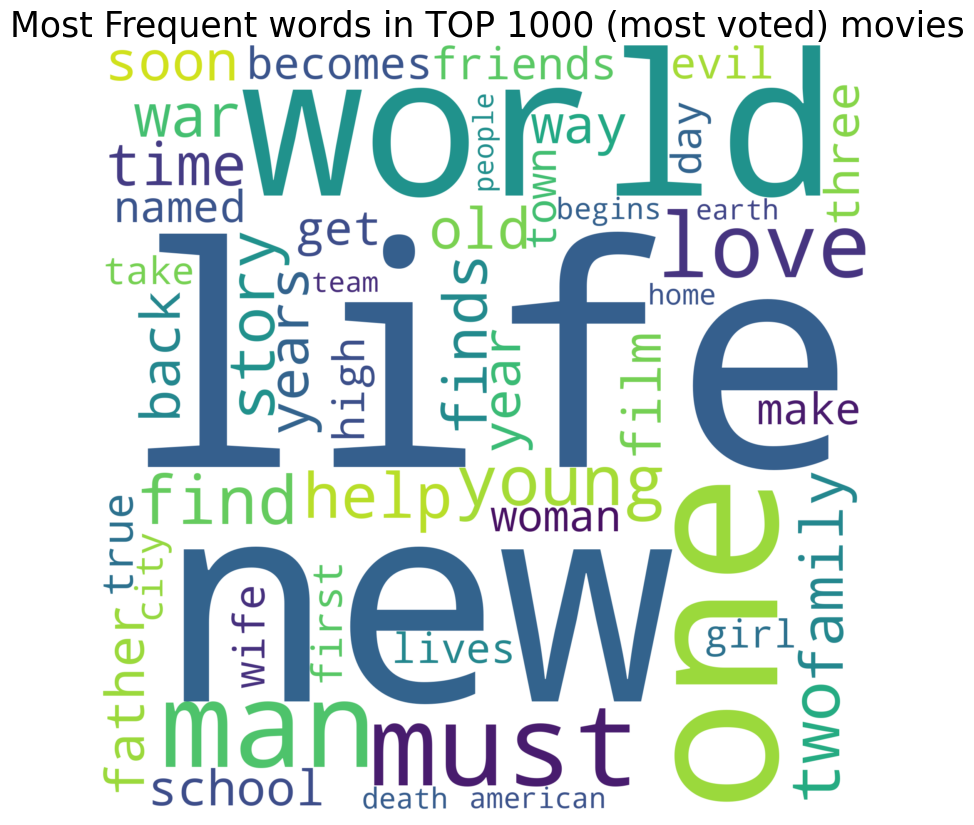

In [49]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

df_aux['overview'] = df_aux.overview.apply(lambda x : x.lower())
df_aux['overview'] = df_aux.overview.apply(lambda x : tokenizer.tokenize(x))
df_aux['overview'] = df_aux.overview.apply(lambda x : [w for w in x if w not in stop_words])
df_aux['overview'] = df_aux.overview.apply(lambda x : ' '.join(x))

word_count = df_aux.overview.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False)
word_count = pd.DataFrame({'word' : word_count.index, 'count': word_count.values})
# Plot the WordCloud
d = {}
for a, x in word_count.values:
    d[a] = x

wordcloud = WordCloud(background_color = 'white',
                      max_words = 50,
                      width = 2000,
                      height = 2000)
wordcloud.generate_from_frequencies(frequencies=d)
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Most Frequent words in TOP 1000 (most voted) movies', fontsize = 25)
plt.show();

In [47]:
top_movies = metadata[metadata['vote_count']>50][:1000]

In [48]:
top_movies['release_date'].head()

10309    1995
39085    2006
7643     1954
33420    2015
29183    2015
Name: release_date, dtype: int64

## Word Cloud for top 1000 movies (based on ratings)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


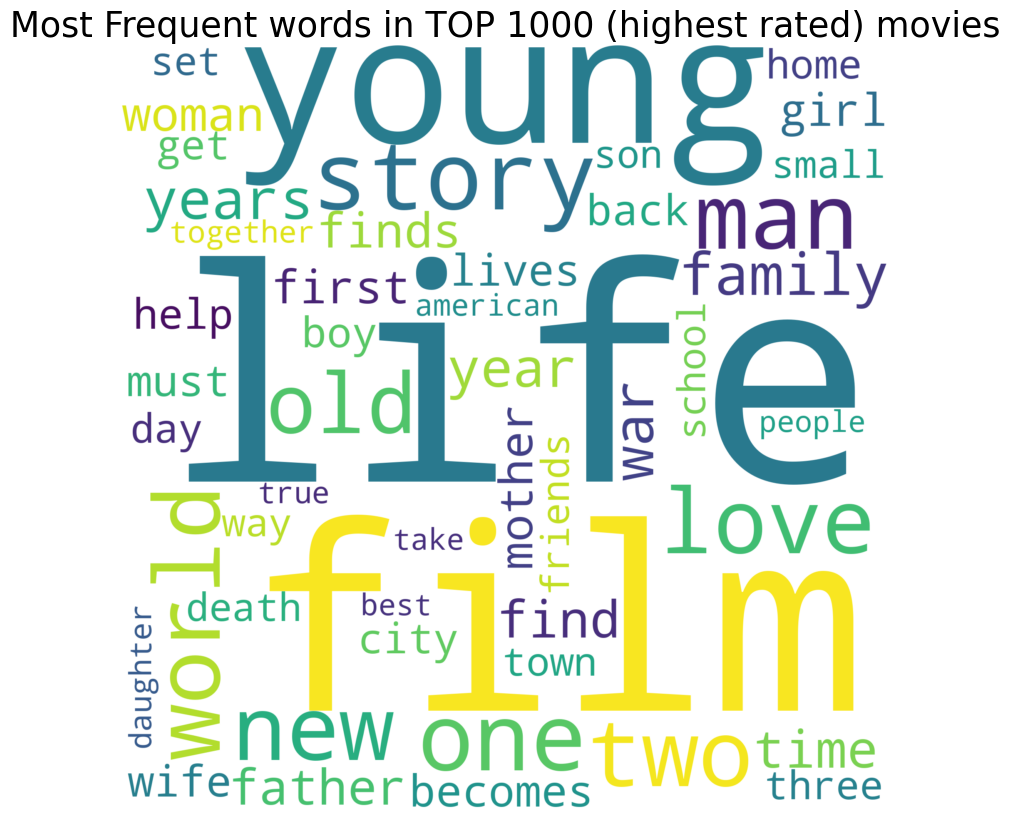

In [50]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

top_movies['overview'] = top_movies.overview.apply(lambda x : x.lower())
top_movies['overview'] = top_movies.overview.apply(lambda x : tokenizer.tokenize(x))
top_movies['overview'] = top_movies.overview.apply(lambda x : [w for w in x if w not in stop_words])
top_movies['overview'] = top_movies.overview.apply(lambda x : ' '.join(x))

word_count = top_movies.overview.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False)
word_count = pd.DataFrame({'word' : word_count.index, 'count': word_count.values})
# Plot the WordCloud
d = {}
for a, x in word_count.values:
    d[a] = x

wordcloud = WordCloud(background_color = 'white',
                      max_words = 50,
                      width = 2000,
                      height = 2000)
wordcloud.generate_from_frequencies(frequencies=d)
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Most Frequent words in TOP 1000 (highest rated) movies', fontsize = 25)
plt.show()

## Word Cloud for top user

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


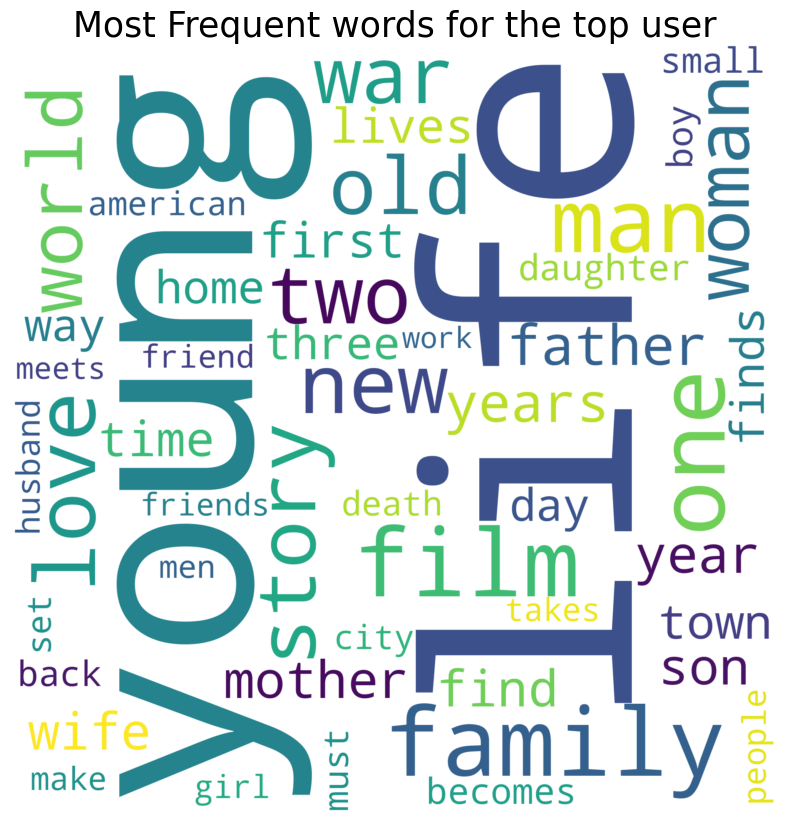

In [51]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')

df_aux_user['overview'] = df_aux_user.overview.apply(lambda x : x.lower())
df_aux_user['overview'] = df_aux_user.overview.apply(lambda x : tokenizer.tokenize(x))
df_aux_user['overview'] = df_aux_user.overview.apply(lambda x : [w for w in x if w not in stop_words])
df_aux_user['overview'] = df_aux_user.overview.apply(lambda x : ' '.join(x))

word_count = df_aux_user.overview.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).sort_values(ascending=False)
word_count = pd.DataFrame({'word' : word_count.index, 'count': word_count.values})
# Plot the WordCloud
d = {}
for a, x in word_count.values:
    d[a] = x

wordcloud = WordCloud(background_color = 'white',
                      max_words = 50,
                      width = 2000,
                      height = 2000)
wordcloud.generate_from_frequencies(frequencies=d)
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Most Frequent words for the top user', fontsize = 25)
plt.show()

## Release year statistics

In [52]:
release_stats = Counter(metadata['release_date'].tolist())

In [53]:
del release_stats[1], release_stats[12], release_stats[22]

In [54]:
release_stats = sorted(release_stats.items(), key=lambda x: x[0])

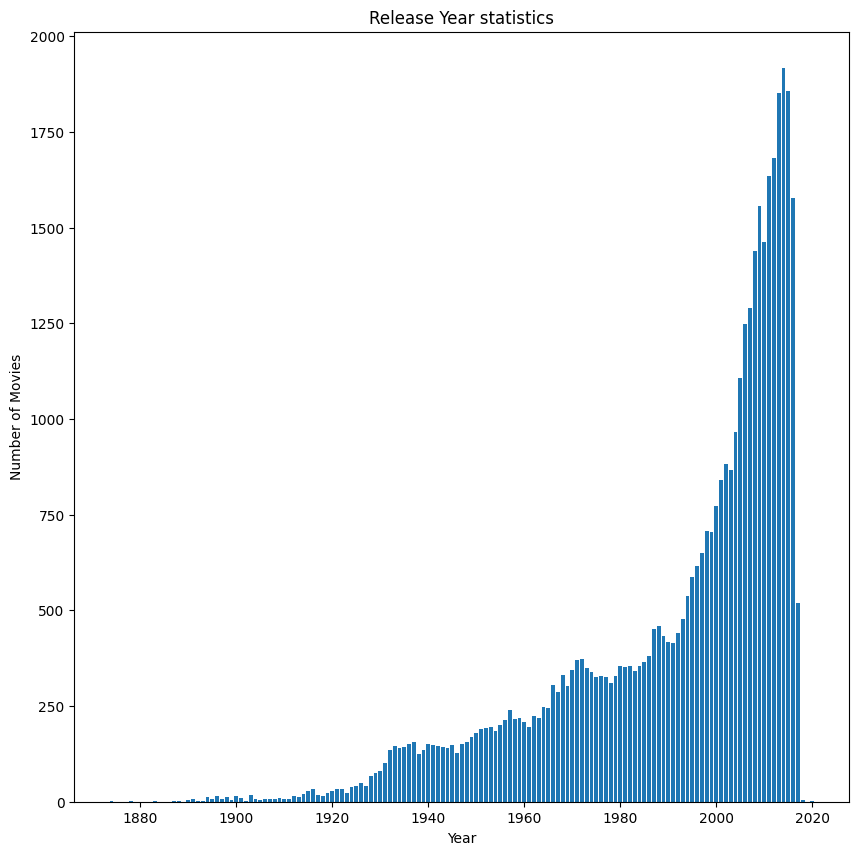

In [55]:
plt.title('Release Year statistics')
plt.bar([i[0] for i in release_stats], [i[1] for i in release_stats])
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.show()